# Решающие деревья (деревья решений, *decision trees*)

## Идея

Дерево решений $-$ это алгоритм, который предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил (*предикатов*). По сути, это напоминает то, как человек принимает решения.

В общем случае решающее дерево $-$ это $k$-ичное дерево с решающими правилами в нелистовых вершинах (узлах) и некотором заключении о целевой функции в листовых вершинах (прогнозом). Чаще всего на практике используются **двоичные решающие деревья**, где в листовых вершинах могут находиться разные объекты:
- класс, который нужно присвоить попавшему туда объекту (в задаче классификации),
- вероятности классов (в задаче классификации),
- непосредственно значение целевой функции (задача регрессии).

| **Пример решающего дерева для классификации** | **Визуализация решающей поверхности для регрессии** |
|:-:|:-:|
| ![](https://yastatic.net/s3/education-portal/media/3_2_41c1793bef_fda82166a3.webp) | ![](https://yastatic.net/s3/education-portal/media/3_3_64f47eb4c8_29f1b64e0b.webp) |

*Источник: Яндекс.Хендбук*

## Теперь чуть более формально:

1. Каждой внутренней вершине $v$ приписан предикат $B_v$: $𝕏→\{0, 1\}$.
2. Каждой листовой вершине $v$ приписан прогноз
$c_v∈𝕐$, где $𝕐$ $-$ область значений целевой переменной (в случае классификации листу может быть также приписан вектор вероятностей классов).
3. Вообще, предикат $B_v$ может иметь, произвольную структуру, но на практике чаще используют просто сравнение с порогом $t$ по какому-то $j$-му признаку: $$B_v(x, t, j)=[x_j≤t]$$

**Важные свойства решающих деревьев**:
- Функция будет кусочно-постоянная, поэтому о градиенте при поиске оптимального решения можно забыть (производная равна нулю везде, где задана).
- Нельзя экстраполировать зависимости за границы области значений обучающей выборки.
- Можно идеально приблизить обучающую выборку и ничего не выучить: построить такое дерево, в каждый лист которого будет попадать только один объект. Поэтому при обучении надо не просто приближать обучающую выборку как можно лучше, но и стремиться оставлять дерево как можно более простым, чтобы результат обладал хорошей обобщающей способностью.

## А как нам эти предикаты найти?

**В очень общих словах**:
> Алгоритм находит признаки, которые позволяют разделить выборку так, чтобы новые части (сплиты) были более однородны. Затем эти части снова делятся на более однородные части и т.д.


Для того, чтобы найти предикаты, используются два основных критерия:
- энтропия (информационный прирост, *information gain*),
- критерий Джини (*Gini index*).

**Энтропию** можно рассматривать как "рандомность" сплита на категориальных данных. Чем выше информационный прирост, тем ниже энтропия и наоборот. В формульном виде: $$\text{Entropy}=- \sum^c_{i=1}p_i*\log_2(p_i),$$ где $c$ $-$ это число классов, а $p_i$ $-$ это вероятность $i$-ого класса.

**Критерий Джини** берет за основу идею, что при стремлении к идеальной однородности сплита вероятность, что два рандомно взятых объекта одинаковы, стремится к $1$. Этот критерий чаще используется при количественных данных и формулируется так: $$\text{Gini}=1-\sum^c_{i=1}(p_i)^2,$$ где $c$ $-$ это число классов, а $p_i$ $-$ это вероятность $i$-ого класса.


## Переобучение

### Гиперпараметры

У решающих деревьев относительно много гиперпараметров:
- критерий (Джини или энтропия)
- максимальная глубина дерева
- минимальный размер сплита / листовой вершины
- максимальное количество рассматриваемых атрибутов
- изменение качества при делении
- и др.

### Стрижка (*pruning*)

Есть два кардинально разных подхода к стрижке:
- Можно проверять изменение качества прямо во время построения дерева и останавливать тренировку в нужный момент (pre-pruning или early stopping).
- Можно построить дерево жадно без ограничений, а затем провести стрижку (pruning), то есть удалить некоторые вершины из дерева так, чтобы итоговое качество упало не сильно, но дерево начало подходить под условия регуляризации.

## Плюсы и минусы

**Плюсы**:
- легко интерпретируются;
- могут проводить нелинейные границы;
- способны справляться как с числовыми, так и с категориальными данными;
- не требуют масштабирования признаков;
- устойчивы к отсутствующим значениям;
- можно использовать комбинации параметров.

**Минусы**:
- легко переобучаются;
- маленькая вариативность в построении;
- очень чувствительны к изменениям в данных;
- в основе лежит неоптимальный жадный алгоритм.

## Практика

### Подготовка

Всякие импорты и установки:

In [ ]:
!pip install category-encoders --q

In [ ]:
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import category_encoders as ce

%matplotlib inline
warnings.filterwarnings('ignore')

Мы будем работать с датасетом характеристик машин, предсказывая их класс.

In [ ]:
!wget https://raw.githubusercontent.com/hse-ling-python/seminars/refs/heads/master/ml/car_evaluation.csv

--2025-02-09 13:36:27--  https://raw.githubusercontent.com/hse-ling-python/seminars/refs/heads/master/ml/car_evaluation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53593 (52K) [text/plain]
Saving to: ‘car_evaluation.csv’

car_evaluation.csv  100%[===================>]  52.34K  --.-KB/s    in 0.05s   

2025-02-09 13:36:28 (1.06 MB/s) - ‘car_evaluation.csv’ saved [53593/53593]



Прочитаем данные, переназвав колонки:

In [ ]:
data = 'car_evaluation.csv'
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

df = pd.read_csv(data, header=None)
df.columns = col_names  # переименуем столбцы

df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Разобъем на признаки и значения и посмотрим на соотношение классов:

In [ ]:
X = df.drop(['class'], axis=1)
y = df['class']

In [ ]:
y.value_counts().sort_index()  # классы неравные

,count
class,
acc,384
good,69
unacc,1210
vgood,65


Поделим наши данные на две выборки:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y
    )

Закодируем категориальные данные:

In [ ]:
encoder = ce.OrdinalEncoder(
    cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
    )

In [ ]:
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [ ]:
X_train.head()

,buying,maint,doors,persons,lug_boot,safety
1512,1,1,1,1,1,1
1433,1,2,2,1,1,2
741,2,1,3,2,2,1
1610,1,1,3,2,3,2
1097,3,1,1,2,3,2


### Дерево при помощи критерия Джини

In [ ]:
# инициализируем модель

clf_gini = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    random_state=0
    )

Обучим модель и посмотрим на предсказания:

In [ ]:
clf_gini.fit(X_train, y_train)
y_pred_gini = clf_gini.predict(X_test)

Посмотрим на качество:

In [ ]:
print(classification_report(y_pred_gini, y_test))

              precision    recall  f1-score   support

         acc       0.80      0.54      0.65       186
        good       0.00      0.00      0.00         0
       unacc       0.90      0.93      0.91       385
       vgood       0.00      0.00      0.00         0

    accuracy                           0.81       571
   macro avg       0.42      0.37      0.39       571
weighted avg       0.86      0.81      0.83       571



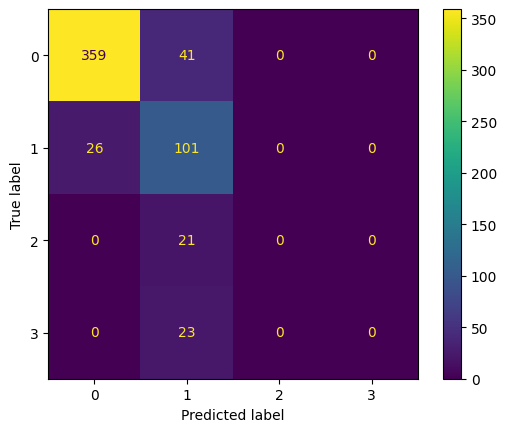

In [ ]:
matrix = confusion_matrix(y_test, y_pred_gini, labels=y.unique(), normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();

Проверим, что дело не в переобучении (спойлер, не в нем):

In [ ]:
y_train_gini = clf_gini.predict(X_train)
print(classification_report(y_train_gini, y_train))

              precision    recall  f1-score   support

         acc       0.82      0.54      0.65       390
        good       0.00      0.00      0.00         0
       unacc       0.89      0.94      0.91       767
       vgood       0.00      0.00      0.00         0

    accuracy                           0.81      1157
   macro avg       0.43      0.37      0.39      1157
weighted avg       0.87      0.81      0.83      1157



Визуализируем (чем темнее цвет, тем более "чистый" лист, то есть более однородный):

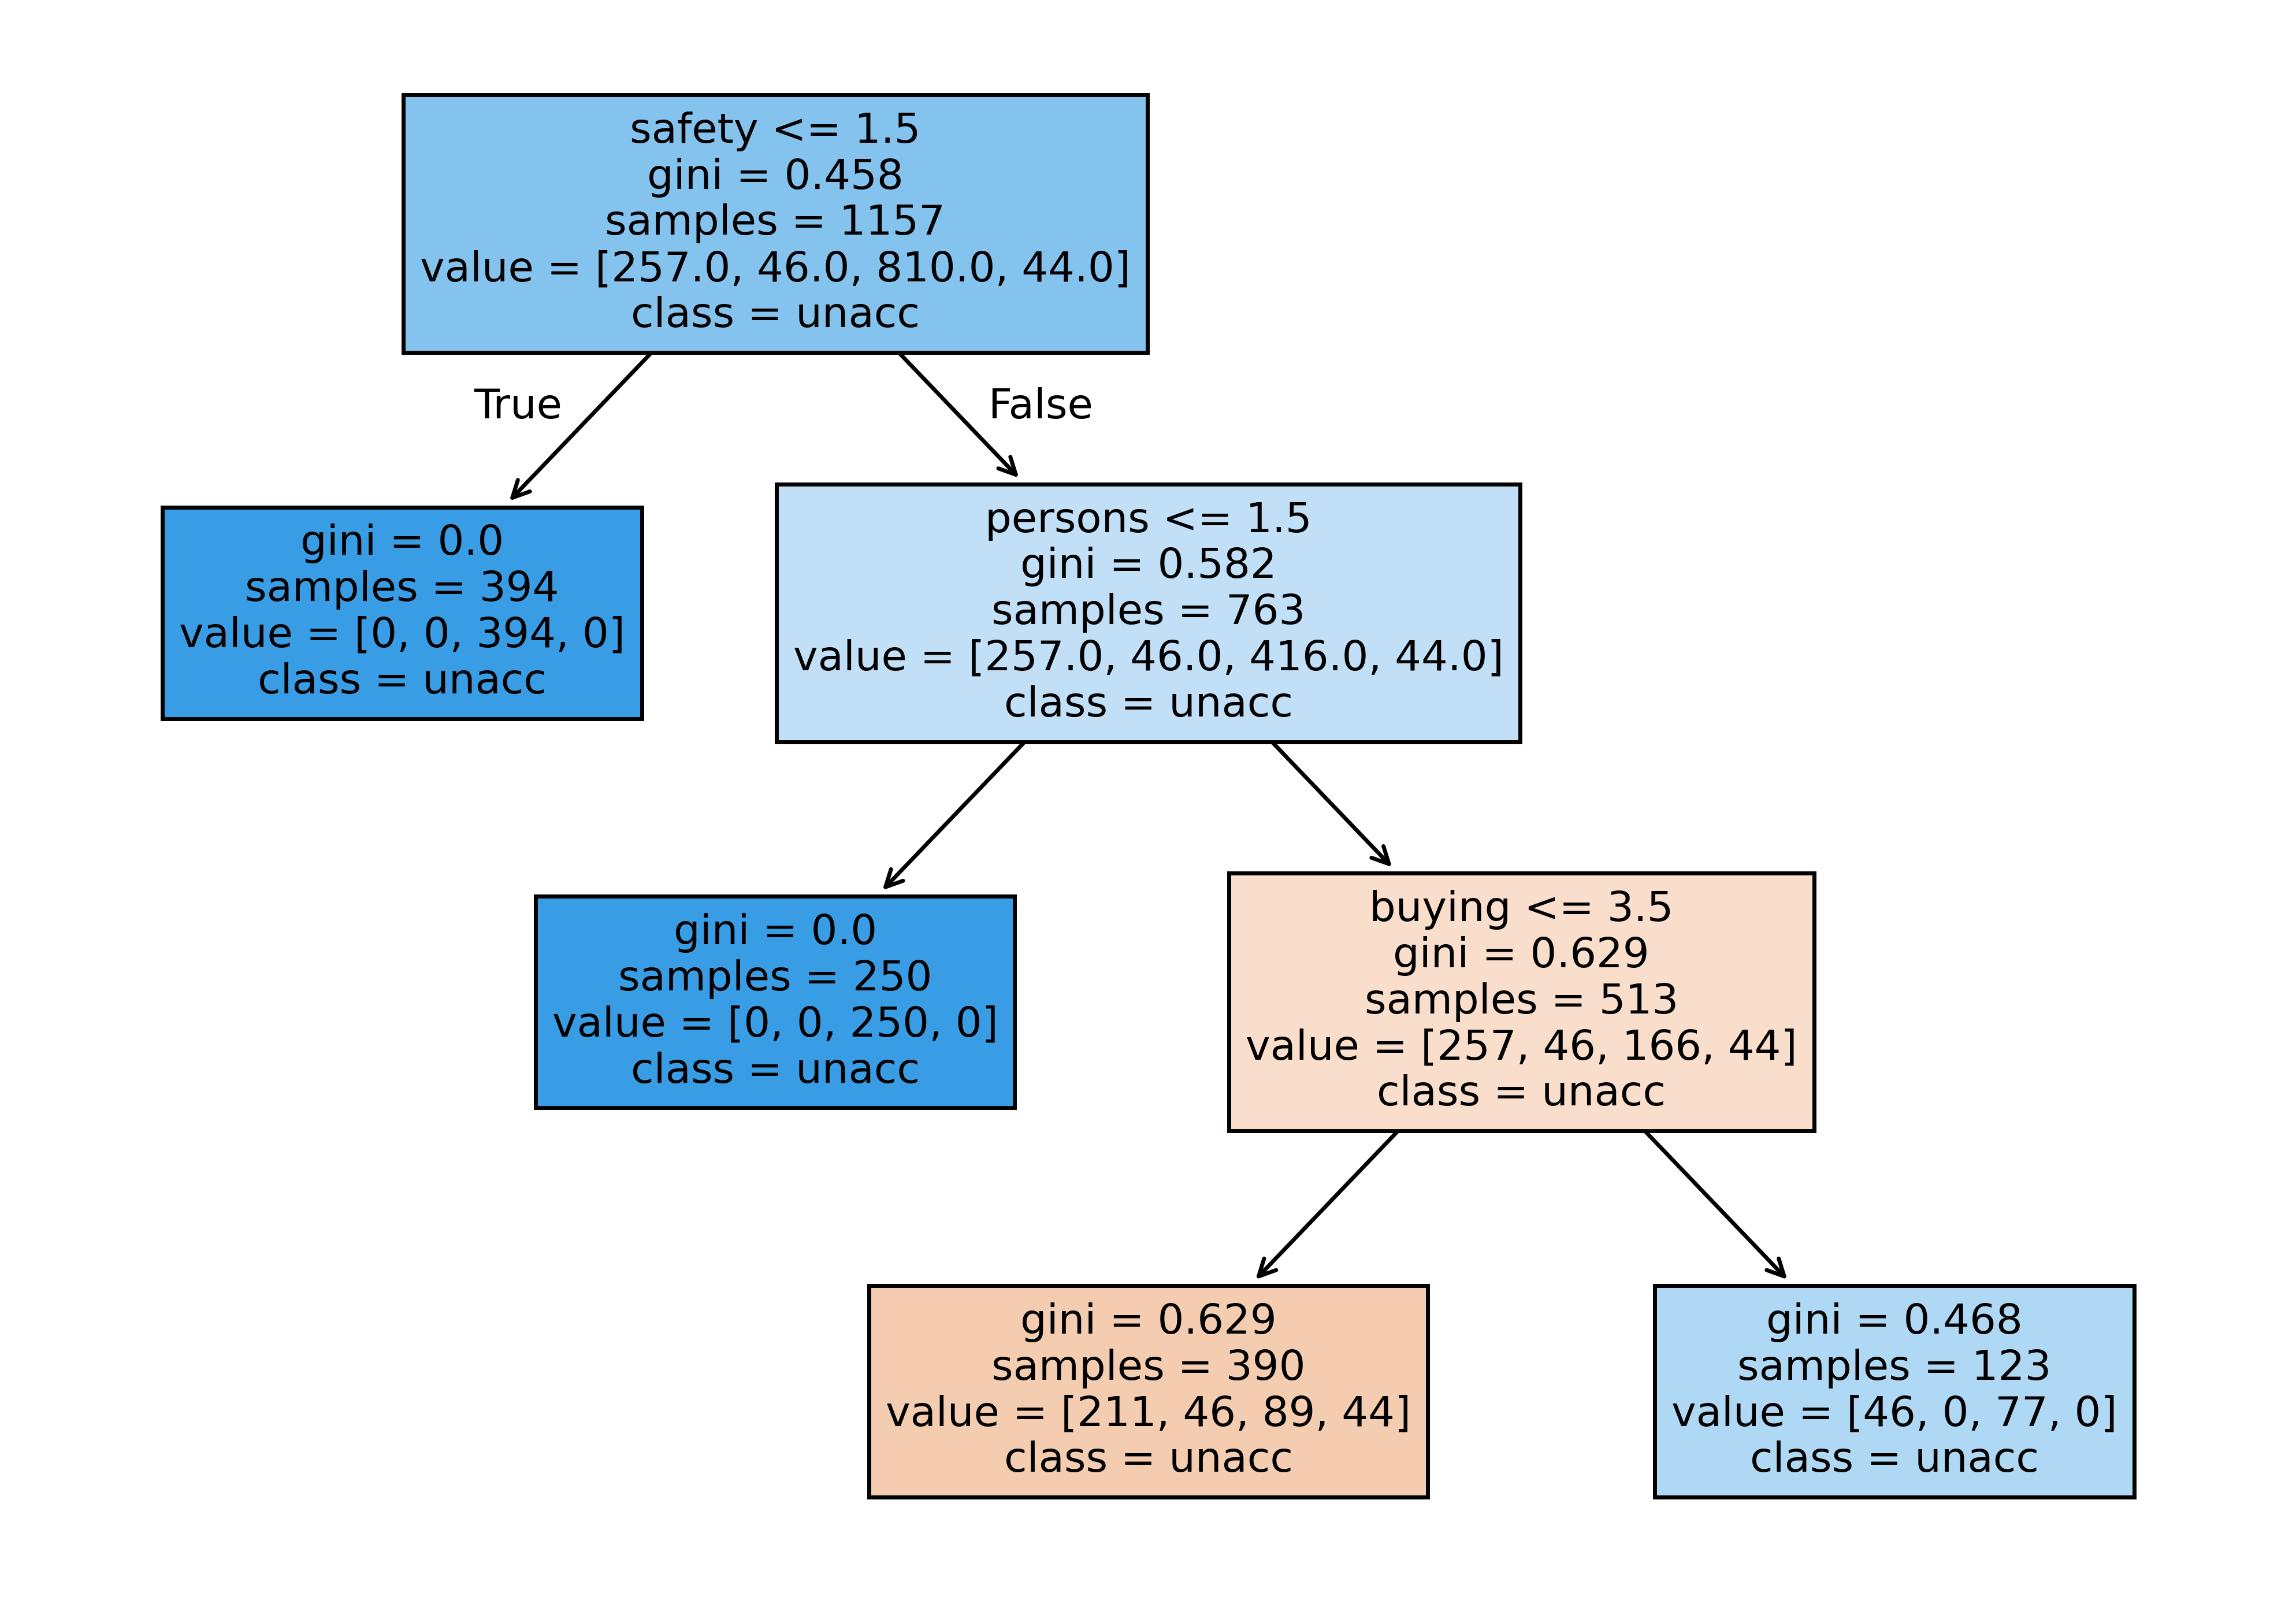

In [ ]:
plt.figure(figsize=(10, 7), dpi=500)
plot_tree(
    clf_gini,
    feature_names=X_train.columns,  # признаки
    class_names=y_train.values,  # классы
    filled=True  # цветом показывается однородность листьев
    );

### Дерево при помощи энтропии

In [ ]:
# инициация модели

clf_en = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=5,
    random_state=0
    )

In [ ]:
# обучение и предсказание

clf_en.fit(X_train, y_train)
y_pred_en = clf_en.predict(X_test)

In [ ]:
# качество

print(classification_report(y_pred_en, y_test))

              precision    recall  f1-score   support

         acc       0.87      0.59      0.70       188
        good       0.00      0.00      0.00         0
       unacc       0.92      0.96      0.94       383
       vgood       0.00      0.00      0.00         0

    accuracy                           0.84       571
   macro avg       0.45      0.39      0.41       571
weighted avg       0.90      0.84      0.86       571



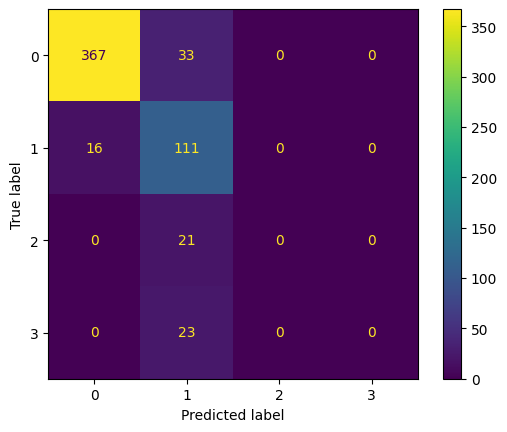

In [ ]:
# качество

matrix = confusion_matrix(y_test, y_pred_en, labels=y.unique(), normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();

In [ ]:
# проверка на переобучение

y_train_en = clf_en.predict(X_train)
print(classification_report(y_train_en, y_train))

              precision    recall  f1-score   support

         acc       0.93      0.61      0.74       388
        good       0.00      0.00      0.00         0
       unacc       0.93      0.98      0.95       769
       vgood       0.00      0.00      0.00         0

    accuracy                           0.85      1157
   macro avg       0.46      0.40      0.42      1157
weighted avg       0.93      0.85      0.88      1157



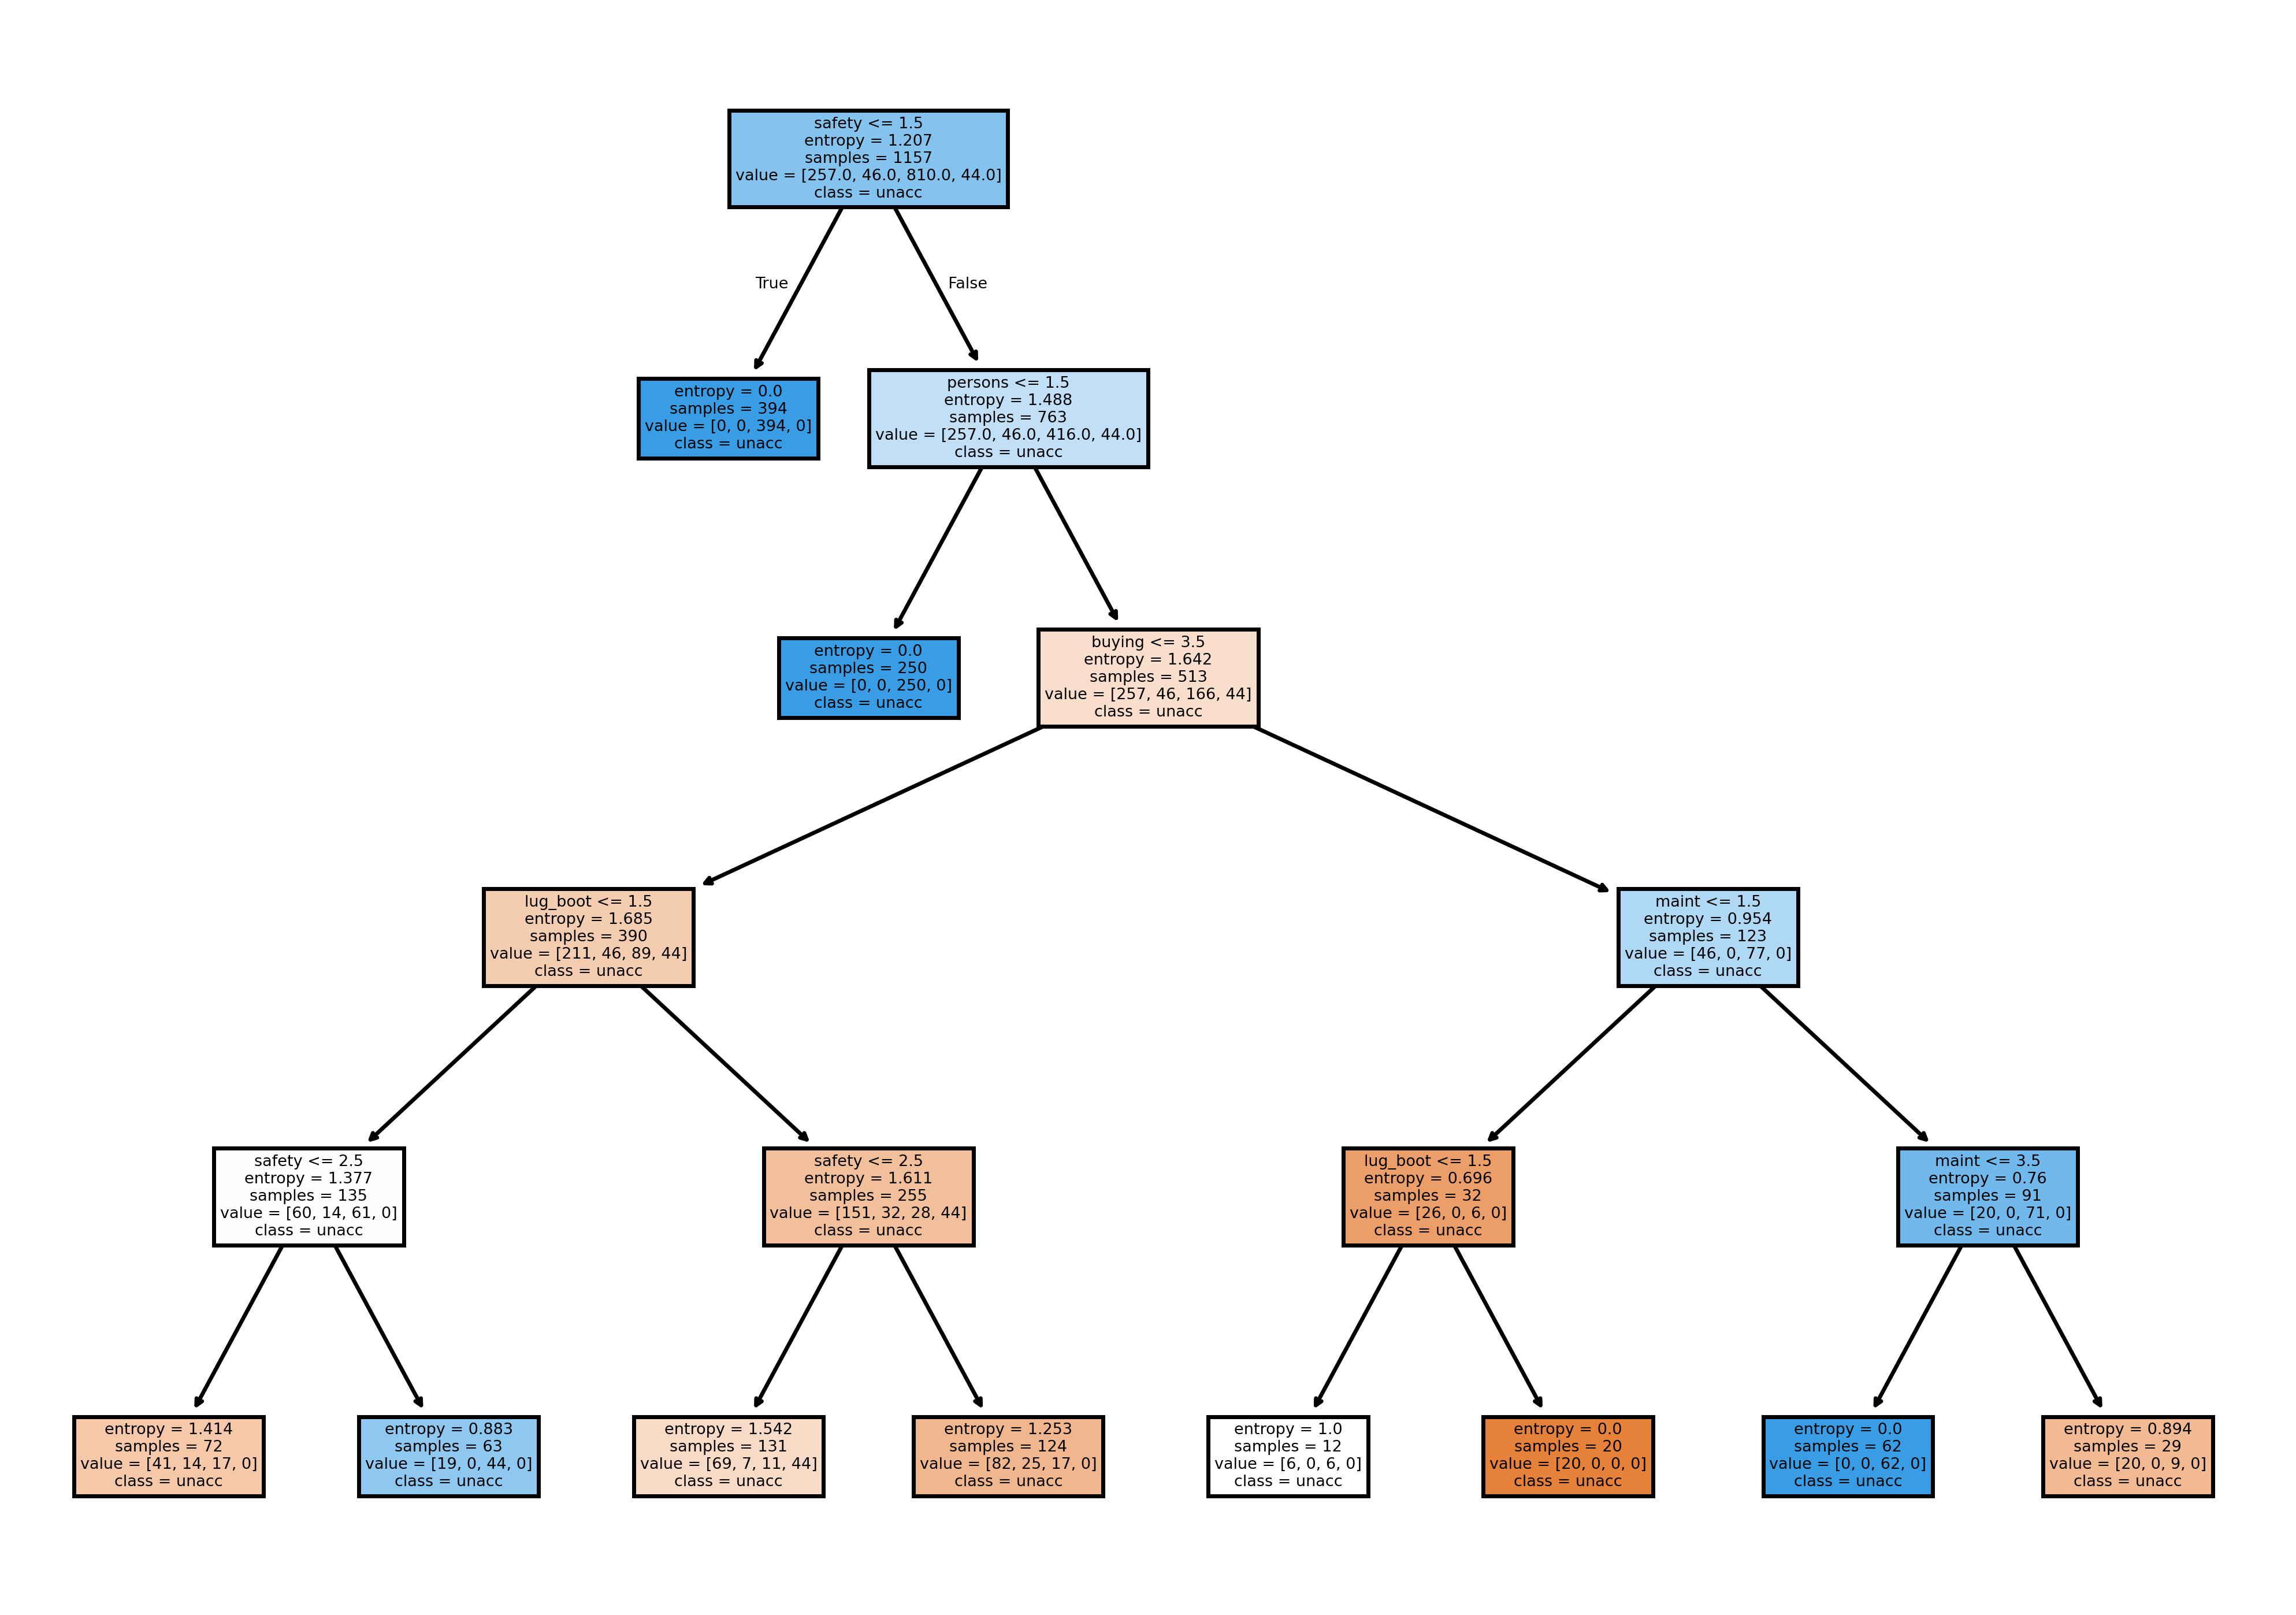

In [ ]:
# вызуализация

plt.figure(figsize=(10, 7), dpi=500)
plot_tree(
    clf_en,
    feature_names=X_train.columns,  # признаки
    class_names=y_train.values,  # классы
    filled=True  # цветом показывается однородность листьев
    );

### Grid Search

In [ ]:
parameters = {
    'criterion': ['gini', 'entropy'],  # критерий
    'max_depth':[3, 5, 7, 9],  # глубина дерева
    'min_samples_split': [2, 4, 6],  # объектов в сплите
    'min_samples_leaf': [1, 2, 3, 4]  # объектов в листе
}

d_tree = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(d_tree, parameters, cv=5, verbose=1)
clf.fit(X_train, y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [ ]:
cv_res = pd.DataFrame(clf.cv_results_)[['params', 'mean_fit_time', 'mean_test_score', 'rank_test_score']]
cv_res.sort_values('rank_test_score').head().style

,params,mean_fit_time,mean_test_score,rank_test_score
40,"{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4}",0.006523,0.942980,1
39,"{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2}",0.006431,0.942980,1
37,"{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 4}",0.006449,0.941252,3
36,"{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.006652,0.941249,4
41,"{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 6}",0.007092,0.938670,5


In [ ]:
the_tree = clf.best_estimator_
y_pred = the_tree.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         acc       0.92      0.85      0.88       138
        good       0.74      0.94      0.83        18
       unacc       0.96      0.98      0.97       391
       vgood       1.00      0.88      0.93        24

    accuracy                           0.94       571
   macro avg       0.90      0.91      0.90       571
weighted avg       0.94      0.94      0.94       571



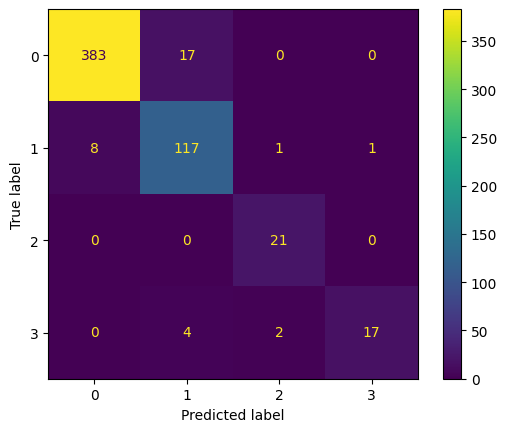

In [ ]:
# качество

matrix = confusion_matrix(y_test, y_pred, labels=y.unique(), normalize=None)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot();